# [Bonus Tasks](svm_segm.ipynb)

In [30]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.ndimage as ndi
import skimage.morphology as morph
from skimage.util import view_as_blocks
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [31]:
def blend_result(img, seg, border_radius=1, interior_opacity=1, interior_opacity_decay=0.9, color=(0,1,0)):
    img  = np.dstack([img] * 3).copy()
    img -= img.min()
    img /= img.max()
    selem  = morph.disk(border_radius)
    seg_bd = np.logical_xor(morph.binary_dilation(seg, selem), morph.binary_erosion(seg, selem))
    mask_decay = ndi.distance_transform_edt(seg)
    for i in range(3):
        opacity = interior_opacity / pow(1 + mask_decay[seg], interior_opacity_decay)
        img[:,:,i][seg] = color[i] * opacity + (1 - opacity) * img[:,:,i][seg]
        img[:,:,i][seg_bd] = color[i]
    return img

In [32]:
patch_sizes = (32, 32)

---

**[Task 1.1.]()** Implement `create_data_matrix`:

In [33]:
def create_data_matrix(image):
    # Teile das Bild in 32x32 Blöcke
    patches = view_as_blocks(image, block_shape=(32, 32))
    
    # Reshape, damit jeder Patch als flacher Vektor (Row-Vector) wird
    patches_reshaped = patches.reshape(-1, 32*32)  # Mache ein 2D-Array (m x n^2)
    
    return patches_reshaped


**[Task 1.2.]()** Implement `create_gt_labels_vector`:

In [34]:
def create_gt_labels_vector(ground_truth):
    # Berechne die Labels für jedes Patch
    patches = view_as_blocks(ground_truth, block_shape=(32, 32))
    labels = []
    
    for patch in patches.reshape(-1, 32*32):  # Patches in flache Vektoren umwandeln
        foreground_percentage = np.sum(patch) / patch.size
        if foreground_percentage > 0.5:
            labels.append(1)  # Objekt (Foreground)
        else:
            labels.append(-1)  # Hintergrund
    
    return np.array(labels)

**[Task 1.3.]()** Create the SVM classifier:

In [35]:
clf = make_pipeline(StandardScaler(), SVC(class_weight='balanced', gamma=0.1))

**[Task 1.3 (a).]()** Create the data matrices for the images `dna-33` and `dna-44`:

In [36]:

# Assuming create_data_matrix function is implemented
image_1 = plt.imread('data/NIH3T3/im/dna-33.png')
image_2 = plt.imread('data/NIH3T3/im/dna-44.png')

# Erstelle die Datenmatrix für beide Trainingsbilder
X_1 = create_data_matrix(image_1)  # Datenmatrix für dna-33.png
X_2 = create_data_matrix(image_2)  # Datenmatrix für dna-44.png


**[Task 1.3 (b).]()** Create the corresponding ground truth label vectors:

In [37]:
# Assuming create_gt_labels_vector function is implemented
gt_1 = plt.imread('data/NIH3T3/gt/33.png')
gt_2 = plt.imread('data/NIH3T3/gt/44.png')

# Erstelle die Label-Vektoren für beide Ground-Truth-Bilder
y_1 = create_gt_labels_vector(gt_1)  # Label-Vektor für das Ground-Truth-Bild 33.png
y_2 = create_gt_labels_vector(gt_2)  # Label-Vektor für das Ground-Truth-Bild 44.png 

**[Task 1.3 (c).]()** Create the *combined* data matrices and ground truth label vectors:

In [38]:

# Stapeln der Datenmatrix und Label-Vektoren für Training
X = np.concatenate([X_1[y_1 != 0], X_2[y_2 != 0]], axis=0)  # Datenmatrix ohne Label = 0
Y = np.concatenate([y_1[y_1 != 0], y_2[y_2 != 0]], axis=0)  # Label-Vektor ohne Label = 0

**[Task 1.3 (d).]()** Train the classifier using the data matrix and label vectors from above:

In [39]:
clf.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', gamma=0.1))])

**[Task 1.4.]()** Implement the function `predict_image`:

In [40]:
def predict_image(image):
    # Schritt 1: Erstelle die Datenmatrix für das Bild
    X = create_data_matrix(image)
    
    # Schritt 2: Verwende den trainierten Klassifikator, um Vorhersagen zu treffen
    predictions = clf.predict(X)
    
    # Schritt 3: Erstelle das binäre Ergebnisbild
    result = np.zeros(image.shape, dtype=bool)  # Initialisiere mit False (Hintergrund)
    
    # Reshape das Ergebnis in Patches und setze True für Vordergrund-Patches
    patches = view_as_blocks(result, block_shape=(32, 32))
    idx = 0
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            if predictions[idx] == 1:  # Wenn das Label 1 (Vordergrund) ist
                result[i*32:(i+1)*32, j*32:(j+1)*32] = True  # Setze den Patch auf True
            idx += 1
    
    return result

Test your implementation:

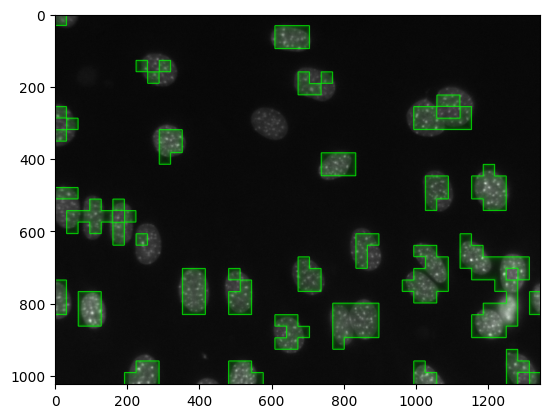

In [41]:
img = plt.imread(f'data/NIH3T3/im/dna-0.png')
seg = predict_image(img)

plt.figure()
plt.imshow(blend_result(img, seg))

**[Task 1.5.]()** Perform batch processing:

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
from skimage import measure

# Helper function to compute the Dice coefficient
def dice_coefficient(segmentation, ground_truth):
    # Ensure both segmentation and ground_truth are boolean or binary (1/0)
    segmentation = segmentation.astype(bool)  # Convert to boolean (True/False)
    ground_truth = ground_truth.astype(bool)  # Convert to boolean (True/False)
    
    # Intersection of the segmentation and ground truth
    intersection = np.sum(segmentation & ground_truth)  # Area where both are True
    return 2 * intersection / (np.sum(segmentation) + np.sum(ground_truth))

# Helper function to perform Otsu thresholding
def otsu_thresholding(image):
    # Convert to grayscale if the image is RGB
    if len(image.shape) > 2:
        image = np.mean(image, axis=2)  # Average across color channels (RGB -> grayscale)
    
    # Apply Otsu's thresholding
    threshold_value = threshold_otsu(image)
    binary_image = image > threshold_value
    return binary_image

# Initialize list to hold Dice coefficients
dice_coefficients = []

# Image indices to loop over
image_indices = [28, 29, 33, 44, 46, 49]

# Loop over each image index
for i in image_indices:
    # Load image and ground truth
    img = plt.imread(f'data/NIH3T3/im/dna-{i}.png')
    gt = plt.imread(f'data/NIH3T3/gt/{i}.png')
    
    
    # Perform patch-based segmentation using the trained SVM classifier
    seg = predict_image(img)
    
    # Ensure the segmentation result is binary
    seg = seg > 0.5  # Adjust based on the output of your segmentation (e.g., > 0.5 for foreground)
    
    # Compute the Dice coefficient for the segmentation
    dice = dice_coefficient(seg, gt)
    dice_coefficients.append(dice)
    
    # Print the Dice coefficient for the current image
    print(f"Image {i} - Dice coefficient: {dice:.4f}")
    
    # Compare the result to Otsu thresholding
    otsu_seg = otsu_thresholding(img)
    otsu_dice = dice_coefficient(otsu_seg, gt)
    
    print(f"Image {i} - Otsu Dice coefficient: {otsu_dice:.4f}")
    print("-" * 50)

# Calculate and print the mean Dice coefficient for all images
mean_dice = np.mean(dice_coefficients)
print(f"Mean Dice coefficient for all images: {mean_dice:.4f}")


Image 28 - Dice coefficient: 0.6880
Image 28 - Otsu Dice coefficient: 0.7529
--------------------------------------------------
Image 29 - Dice coefficient: 0.6743
Image 29 - Otsu Dice coefficient: 0.6476
--------------------------------------------------
Image 33 - Dice coefficient: 0.8243
Image 33 - Otsu Dice coefficient: 0.4652
--------------------------------------------------
Image 44 - Dice coefficient: 0.8343
Image 44 - Otsu Dice coefficient: 0.5758
--------------------------------------------------
Image 46 - Dice coefficient: 0.6210
Image 46 - Otsu Dice coefficient: 0.0761
--------------------------------------------------
Image 49 - Dice coefficient: 0.7285
Image 49 - Otsu Dice coefficient: 0.7925
--------------------------------------------------
Mean Dice coefficient for all images: 0.7284
